# Chapter 3: Modelling and Evaluation - Analyse

In [127]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence


from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from pygam import LinearGAM, s, f, l

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB

from dmba import classificationSummary

# Simple Linear Regression
## The Regression Equation

     Adj Close  FEDFUNDS
0    16.750000      0.12
1    16.855000      0.12
2    18.010000      0.12
3    17.940001      0.11
4    18.370001      0.13
..         ...       ...
158  68.477997      4.10
159  71.818001      4.33
160  72.244003      4.57
161  72.377998      4.65
162  72.566002      4.83

[163 rows x 2 columns]
Intercept: -0.485
Coefficient Exposure: 0.029


C:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


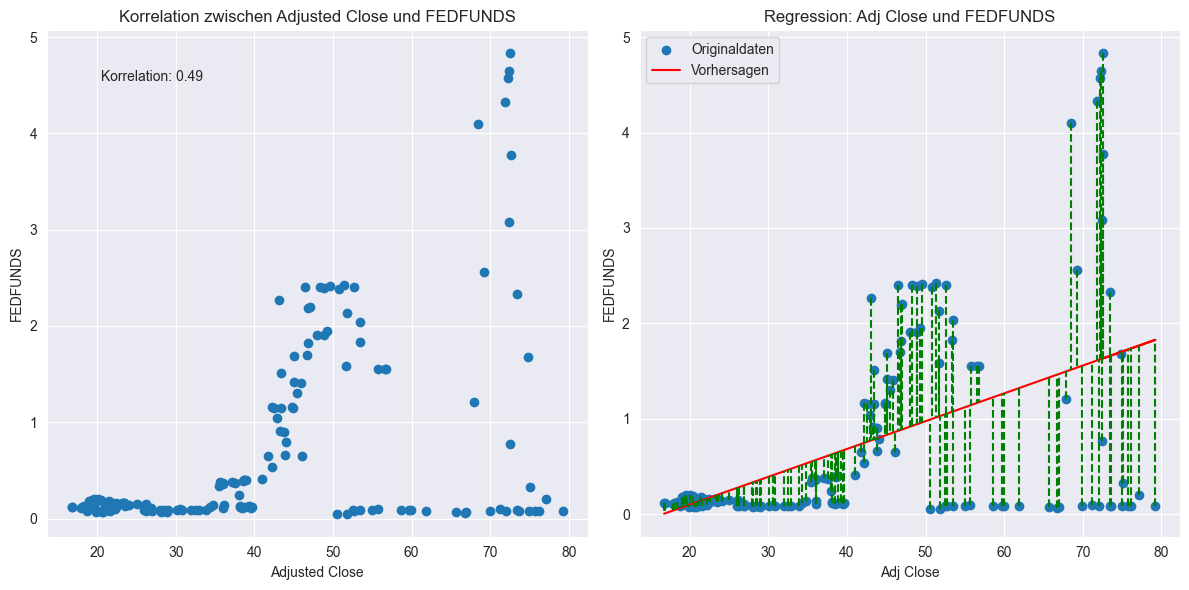

In [128]:
# Daten einlesen
etf_monthly = pd.read_csv('data/iShares Core MSCI World UCITS ETF USD (Acc)_Monthly.csv')
fed_funds = pd.read_csv('data/Leitzins_USA_FED_Banken.csv')

# Daten filtern und kombinieren
etf_filtered = etf_monthly.loc[(etf_monthly['Date'] >= '2009-10-01') & (etf_monthly['Date'] <= '2023-06-01'), ['Adj Close']]
fed_funds_filtered = fed_funds.loc[(fed_funds['DATE'] >= '2009-10-01') & (fed_funds['DATE'] <= '2023-06-01'), ['FEDFUNDS']]

# Daten zusammenführen
# reset_index()-Funktion setzt Index des Datenrahmens zurücksetzt
etf_fed_funds_combined_data = pd.concat([etf_filtered.reset_index(drop=True), fed_funds_filtered.reset_index(drop=True)], axis=1)

# print(len(etf_filtered))
# print(len(fed_funds_filtered))
# # Überprüfen der Datenlängen
# if len(etf_filtered) != len(fed_funds_filtered):
#     raise ValueError("Die Datenlängen stimmen nicht überein.")

# Korrelation berechnen
correlation = etf_fed_funds_combined_data.corr().iloc[0, 1]
# print(correlation)
etf_fed_funds_combined_data.dropna(inplace=True)
#etf_fed_funds_combined_data.fillna(etf_fed_funds_combined_data.mean(), inplace=True)
etf_fed_funds_combined_data.interpolate(inplace=True)

print(etf_fed_funds_combined_data)

#----------------------------------------------------------------------------------------

model = LinearRegression()

# Reshape der Eingabe in die 2D-Array-Form
X = etf_fed_funds_combined_data['Adj Close'].values.reshape(-1, 1)
y = etf_fed_funds_combined_data['FEDFUNDS'].values.reshape(-1, 1)
model.fit(X, y)

fitted = model.predict(X)
residuals = y - fitted

print(f'Intercept: {model.intercept_[0]:.3f}')
print(f'Coefficient Exposure: {model.coef_[0][0]:.3f}')

# Vorhersagen und Residuen berechnen
fitted = model.predict(X)
residuals = y - fitted

# Figure und Subplots erstellen
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Scatterplot der Korrelation
ax1.scatter(etf_fed_funds_combined_data['Adj Close'], etf_fed_funds_combined_data['FEDFUNDS'])
ax1.set_xlabel('Adjusted Close')
ax1.set_ylabel('FEDFUNDS')
ax1.set_title('Korrelation zwischen Adjusted Close und FEDFUNDS')
ax1.text(0.1, 0.9, f'Korrelation: {correlation:.2f}', transform=ax1.transAxes)

# Scatterplot und Linienplot der Regression
ax2.scatter(etf_fed_funds_combined_data['Adj Close'], etf_fed_funds_combined_data['FEDFUNDS'], label='Originaldaten')
ax2.plot(etf_fed_funds_combined_data['Adj Close'], fitted, color='red', label='Vorhersagen')

# Residuenlinien zeichnen
for x, y_actual, y_fitted in zip(etf_fed_funds_combined_data['Adj Close'], etf_fed_funds_combined_data['FEDFUNDS'], fitted):
    ax2.plot([x, x], [y_actual, y_fitted], '--', color='green')

ax2.set_xlabel('Adj Close')
ax2.set_ylabel('FEDFUNDS')
ax2.set_title('Regression: Adj Close und FEDFUNDS')
ax2.legend()

# Diagramme anzeigen
plt.tight_layout()
plt.show()


# Multiple linear regression

In [129]:
etf_monthly = pd.read_csv('data/iShares Core MSCI World UCITS ETF USD (Acc)_Monthly.csv')
fed_funds = pd.read_csv('data/Leitzins_USA_FED_Banken.csv')

etf_filtered = etf_monthly.loc[(etf_monthly['Date'] >= '2009-10-01') & (etf_monthly['Date'] <= '2023-06-01'), ['Adj Close', 'Volume']]
fed_funds_filtered = fed_funds.loc[(fed_funds['DATE'] >= '2009-10-01') & (fed_funds['DATE'] <= '2023-06-01'), ['FEDFUNDS']]

# Daten zusammenführen und fehlende Werte interpolieren
etf_fed_funds_combined_data = pd.concat([etf_filtered.reset_index(drop=True), fed_funds_filtered.reset_index(drop=True)], axis=1)
etf_fed_funds_combined_data.interpolate(inplace=True)

In [130]:
# Daten aus der CSV-Datei laden
leitzins_df = pd.read_csv('data/leitzins Europa.csv')

# Spalten "Obs. Status" und "Obs. Comment" entfernen
leitzins_df = leitzins_df.drop(['obs. status', 'obs. comment'], axis=1)

# Umwandeln des Datums in das Datumsformat
leitzins_df['Date'] = pd.to_datetime(leitzins_df['Date'])

# Filtern der Daten nach dem gewünschten Zeitraum
leitzins_filtered = leitzins_df[(leitzins_df['Date'] >= '1999-01-01') & (leitzins_df['Date'] <= '2023-04-22')]

# Extrahieren von Monat und Jahr aus dem Datum
leitzins_filtered['Monat'] = leitzins_filtered['Date'].dt.month
leitzins_filtered['Jahr'] = leitzins_filtered['Date'].dt.year

# Gruppieren nach Jahr und Monat und Berechnung des Durchschnitts
monatliche_leitzins_df = leitzins_filtered.groupby(['Jahr', 'Monat']).mean()

# Speichern der monatlichen Leitzinswerte in eine neue CSV-Datei
monatliche_leitzins_df.to_csv('data/generatedDatasets/monatliche_leitzins_ezb.csv', index=False)

In [131]:
# CSV-Datei einlesen
fed_funds_customer_monthly = pd.read_csv('data/Leitzins_USA_FED_Kunden.csv')

# Spalte 'DATE' in ein DateTime-Format konvertieren
fed_funds_customer_monthly['DATE'] = pd.to_datetime(fed_funds_customer_monthly['DATE'])

# DataFrame-Index auf 'DATE' setzen
fed_funds_customer_monthly.set_index('DATE', inplace=True)

# Datenreihe resamplen und fehlende Monate auffüllen
fed_funds_customer_monthly = fed_funds_customer_monthly.resample('MS').ffill()

# DataFrame-Index zurücksetzen
fed_funds_customer_monthly = fed_funds_customer_monthly.reset_index()

# CSV-Datei mit aufgefüllten Monaten speichern
fed_funds_customer_monthly.to_csv('data/generatedDatasets/Leitzins_USA_FED_Kunden_aufgefuellt.csv', index=False)

In [132]:
# Auslesen der einzelnen Daten in einer Tabelle

etf_monthly = pd.read_csv('data/iShares Core MSCI World UCITS ETF USD (Acc)_Monthly.csv')
fed_funds_banks_monthly = pd.read_csv('data/Leitzins_USA_FED_Banken.csv')
eu_funds_monthly = pd.read_csv('data/generatedDatasets/monatliche_leitzins_ezb.csv')
fed_funds_customer_monthly_extends = pd.read_csv('data/generatedDatasets/Leitzins_USA_FED_Kunden_aufgefuellt.csv')
eur_usd_exch = pd.read_csv('data/generatedDatasets/combined_etf_currency_data.csv')


etf_monthly_filtered = etf_monthly.loc[(etf_monthly['Date'] >= '2009-10-01') & (etf_monthly['Date'] <= '2023-04-01'), ['Date', 'Adj Close' , 'Volume']]

fed_funds_banks_monthly_filtered = fed_funds_banks_monthly.loc[(fed_funds_banks_monthly['DATE'] >= '2009-10-01') & (fed_funds_banks_monthly['DATE'] <= '2023-04-01'), ['FEDFUNDS']]

eu_funds_monthly_filtered = eu_funds_monthly.loc[(eu_funds_monthly['Date'] >= '2009-10-01') & (eu_funds_monthly['Date'] <= '2023-04-01'), ['Percent per annum']]

fed_funds_banks_monthly_filtered = fed_funds_banks_monthly.loc[(fed_funds_banks_monthly['DATE'] >= '2009-10-01') & (fed_funds_banks_monthly['DATE'] <= '2023-04-01'), ['FEDFUNDS']]

fed_funds_customer_monthly_extends_filtered = fed_funds_customer_monthly_extends.loc[(fed_funds_customer_monthly_extends['DATE'] >= '2009-10-01') & (fed_funds_customer_monthly_extends['DATE'] <= '2023-04-01'), ['PRIME']]

# eur_usd_exch_filtered = eur_usd_exch[(eur_usd_exch['Date'] >= '2009-10-01') & (eur_usd_exch['Date'] <= '2023-04-01'), ['Date','USD_EUR_Exch_Rate']]



pre_regression_combined_data = pd.concat([etf_monthly_filtered.reset_index(drop=True), eu_funds_monthly_filtered.reset_index(drop=True), fed_funds_banks_monthly_filtered.reset_index(drop=True), fed_funds_customer_monthly_extends_filtered.reset_index(drop=True)], axis=1)

pre_regression_combined_data = pre_regression_combined_data.rename(columns={'Percent per annum': 'ezb_funds'})

pre_regression_combined_data = pre_regression_combined_data.rename(columns={'FEDFUNDS': 'fed_funds_for_banks'})

pre_regression_combined_data = pre_regression_combined_data.rename(columns={'PRIME': 'fed_funds_for_cumstomer'})

print(pre_regression_combined_data)


           Date  Adj Close      Volume  ezb_funds  fed_funds_for_banks   
0    2009-10-01  16.750000       850.0   1.000000                 0.12  \
1    2009-11-01  16.855000      1066.0   1.000000                 0.12   
2    2009-12-01  18.010000      1117.0   1.000000                 0.12   
3    2010-01-01  17.940001      2789.0   1.000000                 0.11   
4    2010-02-01  18.370001     96452.0   1.000000                 0.13   
..          ...        ...         ...        ...                  ...   
158  2022-12-01  68.477997   6728267.0   2.177419                 4.10   
159  2023-01-01  71.818001   6731261.0   2.500000                 4.33   
160  2023-02-01  72.244003   5824871.0   2.875000                 4.57   
161  2023-03-01  72.377998  10135602.0   3.161290                 4.65   
162  2023-04-01  72.566002   6208642.0        NaN                 4.83   

     fed_funds_for_cumstomer  
0                       3.25  
1                       3.25  
2                 

In [133]:
subset = ['Adj Close', 'ezb_funds', 'fed_funds_for_banks', ]

print(pre_regression_combined_data[subset].head())

pre_regression_combined_data.to_csv('data/generatedDatasets/multiple_regression_combined_data.csv', index=False)


   Adj Close  ezb_funds  fed_funds_for_banks
0  16.750000        1.0                 0.12
1  16.855000        1.0                 0.12
2  18.010000        1.0                 0.12
3  17.940001        1.0                 0.11
4  18.370001        1.0                 0.13


In [134]:
multiple_regression_combined_data = pd.read_csv('data/generatedDatasets/multiple_regression_combined_data.csv')
multiple_regression_combined_data = multiple_regression_combined_data.dropna(axis=0)

predictors = ['ezb_funds', 'fed_funds_for_banks', 'fed_funds_for_cumstomer']
outcome = 'Adj Close'

adjClose_etf_lm = LinearRegression()
adjClose_etf_lm.fit(multiple_regression_combined_data[predictors], multiple_regression_combined_data[outcome])

print(f'Intercept: {adjClose_etf_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, adjClose_etf_lm.coef_):
    print(f' {name}: {coef}')


Intercept: 28.944
Coefficients:
 ezb_funds: -12.762649062641268
 fed_funds_for_banks: 7.228215416972685
 fed_funds_for_cumstomer: 3.248414184528474


## Weighted regression

In [135]:
multiple_regression_combined_data = pd.read_csv('data/generatedDatasets/multiple_regression_combined_data.csv')
multiple_regression_combined_data = multiple_regression_combined_data.dropna(axis=0)

# Definiere die Prädiktoren und das Ziel
predictors = ['ezb_funds', 'fed_funds_for_banks', 'fed_funds_for_cumstomer']
outcome = 'Adj Close'

# Gewichtung basierend auf dem Volumen
weights = multiple_regression_combined_data['Volume']

# Initialisiere das lineare Regressionsmodell mit gewichteten Daten
adjClose_etf_wt = LinearRegression()
adjClose_etf_wt.fit(multiple_regression_combined_data[predictors], multiple_regression_combined_data[outcome], sample_weight=weights)

# Zeige die Ergebnisse an
print('Berechnung basierend auf der Gewichtung des Volumens')
print(f'Intercept: {adjClose_etf_wt.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, adjClose_etf_wt.coef_):
    print(f' {name}: {coef}')



Berechnung basierend auf der Gewichtung des Volumens
Intercept: 87.835
Coefficients:
 ezb_funds: 6.5129858533096225
 fed_funds_for_banks: 8.114393693831992
 fed_funds_for_cumstomer: -9.556114176848865


In [136]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Daten aus der CSV-Datei lesen
multiple_regression_combined_data = pd.read_csv('data/generatedDatasets/multiple_regression_combined_data.csv')
multiple_regression_combined_data = multiple_regression_combined_data.dropna(axis=0)

# Datum in Spalte "Date" in ein Datumsobjekt konvertieren
multiple_regression_combined_data['Date'] = pd.to_datetime(multiple_regression_combined_data['Date'])

# Berechnung der monatlichen Rendite
multiple_regression_combined_data['Monthly Return'] = (multiple_regression_combined_data['Adj Close'] - multiple_regression_combined_data['Adj Close'].shift(1)) / multiple_regression_combined_data['Adj Close'].shift(1) * 100

# NaN-Werte in der Spalte "Monthly Return" mit 0 ersetzen
multiple_regression_combined_data['Monthly Return'].fillna(0, inplace=True)

multiple_regression_combined_data.to_csv('data/generatedDatasets/multiple_regression_combined_data_with_return.csv')

# Definiere die Prädiktoren und das Ziel
predictors = ['ezb_funds', 'fed_funds_for_banks', 'fed_funds_for_cumstomer']
outcome = 'Monthly Return'

# Trainingsdaten: Daten bis zum maximalen Datum
# Filterung der Daten nur Zeilen deren Datum kleiner oder gleich dem maximalen Datum in der Spalte "Date" --> Erhaltung von Trainingsdaten, die bis zum maximalen Datum reichen
train_data = multiple_regression_combined_data[multiple_regression_combined_data['Date'] <= multiple_regression_combined_data['Date'].max()]

# Modell initialisieren und trainieren
# train_data[predictors] sind die unabhängigen Variablen (Prädiktoren)
# train_data[outcome] ist die abhängige Variable (Ziel).
monthy_return_wl = LinearRegression()
monthy_return_wl.fit(train_data[predictors], train_data[outcome])

# Vorhersage für den 1. August 2023 treffen
# [pd.to_datetime('2023-08-01'), 0, 0, 0]], columns=['Date'] + predictors ist notwendig um die Datenstruktur für das trainierten Modell zu verwenden
# Wert 0 wird für alle Prädiktoren (ezb_funds, fed_funds_for_banks, fed_funds_for_cumstomer) verwendet, da es sich um eine Vorhersage handelt und keine tatsächlichen Werte für diese Variablen vorliegen
prediction_data = pd.DataFrame([[pd.to_datetime('2023-08-01'), 0, 0, 0]], columns=['Date'] + predictors)
prediction = monthy_return_wl.predict(prediction_data[predictors])

# Intercept und Koeffizienten ausgeben
print('Intercept:', monthy_return_wl.intercept_)
print('Coefficients:')
for name, coef in zip(predictors, monthy_return_wl.coef_):
    print(f' {name}: {coef}')

print()
print('Vorhersage für den 01.08.2023:')
print(f'Monthly Return: {prediction[0]:.2f}')


Intercept: 5.791302398736291
Coefficients:
 ezb_funds: -0.10480668069458605
 fed_funds_for_banks: 1.0925324558159328
 fed_funds_for_cumstomer: -1.452775408968976

Vorhersage für den 01.08.2023:
Monthly Return: 5.79


In [137]:
pd.concat([
    pd.DataFrame({
        'predictor': ['intercept'],
        'adj_close_lm': adjClose_etf_lm.intercept_,
        'adj_close_wt': adjClose_etf_wt.intercept_,
        'monthy_return_wl': monthy_return_wl.intercept_
    }),
    pd.DataFrame({
        'predictor': predictors,
        'adj_close_lm': adjClose_etf_lm.coef_,
        'adj_close_wt': adjClose_etf_wt.coef_,
        'monthy_return_wl': monthy_return_wl.coef_
    }),

])

,predictor,adj_close_lm,adj_close_wt,monthy_return_wl
0,intercept,28.944295,87.834845,5.791302
0,ezb_funds,-12.762649,6.512986,-0.104807
1,fed_funds_for_banks,7.228215,8.114394,1.092532
2,fed_funds_for_cumstomer,3.248414,-9.556114,-1.452775


# Klassifikation
## Kernidee der Klassifikation
Das Ziel der Klassifikation in Data Science ist es, Muster und Zusammenhänge in Daten zu identifizieren, um Vorhersagen oder Klassifikationen für neue, unbekannte Datenpunkte zu treffen. Die Klassifikation ist ein überwachtes Lernverfahren, bei dem ein Algorithmus auf der Grundlage von Trainingsdaten lernt, wie verschiedene Merkmale oder Variablen verwendet werden können, um Objekte oder Ereignisse in vordefinierte Klassen zu kategorisieren.

Die Prädiktion oder Vorhersage ist das Hauptziel der Klassifikation. Indem wir historische oder gelabelte Daten verwenden, um ein Klassifikationsmodell zu erstellen, können wir dieses Modell auf neue, ungelabelte Daten anwenden und vorhersagen, zu welcher Klasse ein bestimmter Datenpunkt gehört. Das Modell lernt aus den vorhandenen Daten und erfasst Muster, um Entscheidungsregeln abzuleiten und unbekannte Datenpunkte in vordefinierte Klassen zu klassifizieren.

Die Klassifikation findet in verschiedenen Anwendungsbereichen Anwendung, wie z.B. Betrugserkennung, medizinische Diagnose, Kundenverhalten, Spam-Erkennung und vieles mehr. Durch die Klassifikation können Datenwissenschaftler und Analysten wichtige Einblicke gewinnen, fundierte Entscheidungen treffen und zukünftige Ereignisse vorhersagen.

|           | Logistische Regression | Diskriminanzanalyse | Naiver Bayes-Klassifikator |
|-----------|-----------------------|---------------------|----------------------------|
| Annahmen  | Logistische Verteilung der abhängigen Variablen | Multivariate Normalverteilung der Daten | Unabhängigkeit der Merkmale |
| Entscheidungsgrenzen | Linear oder nicht-linear | Lineare Diskriminanzfunktionen | Wahrscheinlichkeitsbasiert |
| Datenverteilung | Robust gegenüber Ausreißern und nicht normalverteilten Daten | Empfindlich auf Verletzungen der Annahme multivariater Normalverteilung | Robust gegenüber nicht normalverteilten Daten |
| Datenanzahl | Funktioniert gut mit kleinen Datensätzen | Erfordert ausreichende Anzahl von Datenpunkten im Verhältnis zur Anzahl der Merkmale | Funktioniert gut mit kleinen Datensätzen |
| Interpretierbarkeit | Interpretation der Koeffizienten als Beitrag der Merkmale zur Vorhersage | Informationen über lineare Diskriminanzfunktionen und Merkmalsbeiträge | Informationen über Merkmals- und Klassenwahrscheinlichkeiten |


## Discriminant Analysis

In [138]:
multiple_regression_combined_data = pd.read_csv(
    'data/generatedDatasets/multiple_regression_combined_data_with_return.csv')

multiple_regression_combined_data['Comparison'] = multiple_regression_combined_data['Monthly Return'].apply(
    lambda x: 'positiv' if x > 0 else 'negativ' if x < 0 else 'stabil')

multiple_regression_combined_data.to_csv(
    'data/generatedDatasets/multiple_regression_combined_data_with_return_comparison.csv')

predictors = ['ezb_funds', 'fed_funds_for_banks']
outcome = 'Comparison'

# Entferne alle Zeilen mit Null- oder NaN-Werten
multiple_regression_combined_data.dropna(inplace=True)

# Daten für die Diskriminanzanalyse auswählen
X = multiple_regression_combined_data[predictors]
y = multiple_regression_combined_data[outcome]

# # Modell initialisieren und trainieren
# model = LinearDiscriminantAnalysis()
# model.fit(X, y)
#
# # Vorhersage für die Trainingsdaten machen
# predictions = model.predict(X)
#
# # Auswertung der Vorhersage
# accuracy = model.score(X, y)
# print(f'Accuracy: {accuracy:.2f}')
#
# # Koeffizienten ausgeben
# print('Coefficients:')
# for name, coef in zip(predictors, model.coef_[0]):
#     print(f' {name}: {coef}')
#
#
# X = multiple_regression_combined_data[predictors]
# y = multiple_regression_combined_data[outcome]

etf_lda = LinearDiscriminantAnalysis()
etf_lda.fit(X, y)

# je größer der Score desto besser ist der Aussagekraft
# je kleiner der Score desto schlechter ist der Aussagekraft

print(pd.DataFrame(etf_lda.scalings_, index=X.columns))

                            0         1
ezb_funds           -1.167411 -1.260182
fed_funds_for_banks  0.908554 -0.492396


In [139]:
pred = pd.DataFrame(etf_lda.predict_proba(multiple_regression_combined_data[predictors]),
                    columns=etf_lda.classes_)
print(pred.head())
# print()
# print(pred['positiv'])

    negativ   positiv    stabil
0  0.308577  0.667728  0.023695
1  0.308577  0.667728  0.023695
2  0.308577  0.667728  0.023695
3  0.308440  0.667692  0.023868
4  0.308714  0.667763  0.023523


[0.47292932 0.50714806]


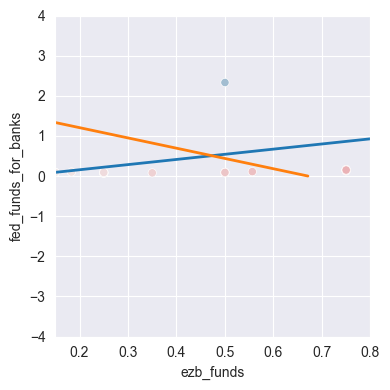

In [140]:
# Use scalings and center of means to determine decision boundary
center = np.mean(etf_lda.means_, axis=0)
print(center)
slope = - etf_lda.scalings_[0] / etf_lda.scalings_[1]
intercept = center[1] - center[0] * slope

# payment_inc_ratio for borrower_score of 0 and 20
x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([multiple_regression_combined_data, pred['positiv']], axis=1)
lda_df.head()

fig, ax = plt.subplots(figsize=(4, 4))
g = sns.scatterplot(x='ezb_funds', y='fed_funds_for_banks',
                    hue='positiv', data=lda_df,
                    palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),
                    ax=ax, legend=False)

ax.set_ylim(-4, 4)
ax.set_xlim(0.15, 0.8)
ax.plot((x_0, x_20), (0, 20), linewidth=2)

plt.tight_layout()
plt.show()


## The Naiver Bayes

In [141]:
from sklearn.model_selection import train_test_split

multiple_regression_combined_data = pd.read_csv(
    'data/generatedDatasets/multiple_regression_combined_data_with_return.csv')

multiple_regression_combined_data['Comparison'] = multiple_regression_combined_data['Monthly Return'].apply(
    lambda x: 'positiv' if x > 0 else 'negativ' if x < 0 else 'stabil')

multiple_regression_combined_data.to_csv(
    'data/generatedDatasets/multiple_regression_combined_data_with_return_comparison.csv')

predictors = ['ezb_funds', 'fed_funds_for_banks']
outcome = 'Comparison'

# Aufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Naive Bayes Klassifikator erstellen und trainieren
naive_model = MultinomialNB(alpha=1e-10, fit_prior=False)
naive_model.fit(X_train, y_train)

# Vorhersagen auf Testdaten machen
y_pred = naive_model.predict(X_test)

# Genauigkeit der Vorhersagen auswerten
accuracy = accuracy_score(y_test, y_pred)

cl = pd.get_dummies(multiple_regression_combined_data.loc[146:146, predictors])
print('predicted class: ', naive_model.predict(cl)[0])
print('predicted probabilities', )
probabilities = pd.DataFrame(naive_model.predict_proba(cl), columns=naive_model.classes_)
print(probabilities)

predicted class:  negativ
predicted probabilities
   negativ   positiv    stabil
0  0.34753  0.346162  0.306308


## Logistische Regression